# Ví dụ 1

Thuật toán EM xây dựng từ numpy

Sử dụng dữ liệu 2D nhân tạo số chiều 2, ma trận hiệp phương sai được chọn để trục của cụm dữ liệu không song song với trục tọa độ

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal


from numpy import random
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
from scipy.stats import multivariate_normal


In [40]:
class GMM():
    def __init__(self, k, dim, init_mu=None, init_sigma=None, init_pi=None, colors=None):
        '''
        Define a model with known number of clusters and dimensions.
        input:
            - k: Number of Gaussian clusters
            - dim: Dimension 
            - init_mu: initial value of mean of clusters (k, dim)
                       (default) random from uniform[-10, 10]
            - init_sigma: initial value of covariance matrix of clusters (k, dim, dim)
                          (default) Identity matrix for each cluster
            - init_pi: initial value of cluster weights (k,)
                       (default) equal value to all cluster i.e. 1/k
            - colors: Color valu for plotting each cluster (k, 3)
                      (default) random from uniform[0, 1]
        '''
        self.k = k
        self.dim = dim
        if(init_mu is None):
            init_mu = random.rand(k, dim)*20 - 10
        self.mu = init_mu
        if(init_sigma is None):
            init_sigma = np.zeros((k, dim, dim))
            for i in range(k):
                init_sigma[i] = np.eye(dim)
        self.sigma = init_sigma
        if(init_pi is None):
            init_pi = np.ones(self.k)/self.k
        self.pi = init_pi
        if(colors is None):
            colors = random.rand(k, 3)
            for i in range(k):
                colors[i, 2] = i/k
        self.colors = colors
    
    def init_em(self, X):
        '''
        Initialization for EM algorithm.
        input:
            - X: data (batch_size, dim)
        '''
        self.data = X
        self.num_points = X.shape[0]
        self.z = np.zeros((self.num_points, self.k))
    
    def e_step(self):
        '''
        E-step of EM algorithm.
        '''
        for i in range(self.k):
            self.z[:, i] = self.pi[i] * multivariate_normal.pdf(self.data, mean=self.mu[i], cov=self.sigma[i])
        self.z /= self.z.sum(axis=1, keepdims=True)
    
    def m_step(self):
        '''
        M-step of EM algorithm.
        '''
        sum_z = self.z.sum(axis=0)
        self.pi = sum_z / self.num_points
        self.mu = np.matmul(self.z.T, self.data)
        self.mu /= sum_z[:, None]
        for i in range(self.k):
            j = np.expand_dims(self.data, axis=1) - self.mu[i]
            s = np.matmul(j.transpose([0, 2, 1]), j)
            self.sigma[i] = np.matmul(s.transpose(1, 2, 0), self.z[:, i] )
            self.sigma[i] /= sum_z[i]
            
    def log_likelihood(self, X):
        '''
        Compute the log-likelihood of X under current parameters
        input:
            - X: Data (batch_size, dim)
        output:
            - log-likelihood of X: Sum_n Sum_k log(pi_k * N( X_n | mu_k, sigma_k ))
        '''
        ll = []
        for d in X:
            tot = 0
            for i in range(self.k):
                tot += self.pi[i] * multivariate_normal.pdf(d, mean=self.mu[i], cov=self.sigma[i])
            ll.append(np.log(tot))
        return np.sum(ll)
    
    def plot_gaussian(self, mean, cov, ax, n_std=3.0, facecolor='none', **kwargs):
        '''
        Utility function to plot one Gaussian from mean and covariance.
        '''
        pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
        ell_radius_x = np.sqrt(1 + pearson)
        ell_radius_y = np.sqrt(1 - pearson)
        ellipse = Ellipse((0, 0),
            width=ell_radius_x * 2,
            height=ell_radius_y * 2,
            facecolor=facecolor,
            **kwargs)
        scale_x = np.sqrt(cov[0, 0]) * n_std
        mean_x = mean[0]
        scale_y = np.sqrt(cov[1, 1]) * n_std
        mean_y = mean[1]
        transf = transforms.Affine2D() \
            .rotate_deg(45) \
            .scale(scale_x, scale_y) \
            .translate(mean_x, mean_y)
        ellipse.set_transform(transf + ax.transData)
        return ax.add_patch(ellipse)
    
    
    def assign_clusters(self):
        '''
        Assign cluster labels to data points based on their highest posterior probability.
        '''
        cluster_labels = np.argmax(self.z, axis=1)
        return cluster_labels


    def draw(self, ax, n_std=2.0, facecolor='none', **kwargs):
        '''
        Function to draw the Gaussians.
        Note: Only for two-dimensionl dataset
        '''
        if(self.dim != 2):
            print("Drawing available only for 2D case.")
            return
        for i in range(self.k):
            self.plot_gaussian(self.mu[i], self.sigma[i], ax, n_std=n_std, edgecolor=self.colors[i], **kwargs)

In [41]:
def gen_data(k=3, dim=2, points_per_cluster=200, lim=[-10, 10]):
    '''
    Generates data from a random mixture of Gaussians in a given range.
    Will also plot the points in case of 2D.
    input:
        - k: Number of Gaussian clusters
        - dim: Dimension of generated points
        - points_per_cluster: Number of points to be generated for each cluster
        - lim: Range of mean values
    output:
        - X: Generated points (points_per_cluster*k, dim)
    '''
    x = []
    mean = random.rand(k, dim)*(lim[1]-lim[0]) + lim[0]
    for i in range(k):
        cov = random.rand(dim, dim+10)
        cov = np.matmul(cov, cov.T)
        _x = np.random.multivariate_normal(mean[i], cov, points_per_cluster)
        x += list(_x)
    x = np.array(x)
    if(dim == 2):
        fig = plt.figure()
        ax = fig.gca()
        ax.scatter(x[:,0], x[:,1], s=3, alpha=0.4)
        ax.autoscale(enable=True) 
    return x

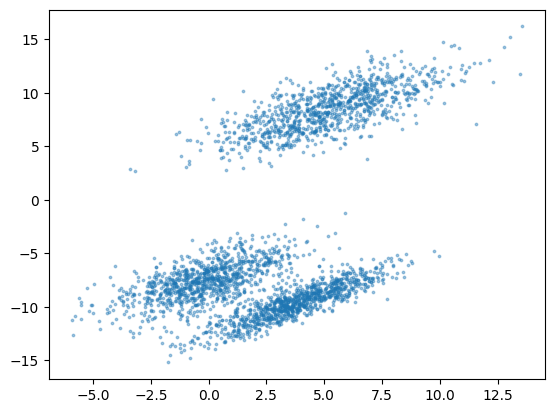

In [42]:
# Generate random 2D data with 3 clusters 
X = gen_data(k=3, dim=2, points_per_cluster=1000)

In [43]:
X.shape

(3000, 2)

In [119]:
print(X[1:3])

[[15 81]
 [16  6]]


In [44]:
# Create a Gaussian Mixture Model
gmm = GMM(3, 2)

In [45]:
def plot(title):
    '''
    Draw the data points and the fitted mixture model.
    input:
        - title: title of plot and name with which it will be saved.
    '''
    fig = plt.figure(figsize=(8, 8))
    ax = fig.gca()
    ax.scatter(X[:, 0], X[:, 1], s=3, alpha=0.4)
    ax.scatter(gmm.mu[:, 0], gmm.mu[:, 1], c=gmm.colors)
    gmm.draw(ax, lw=3)
    ax.set_xlim((-22, 22))
    ax.set_ylim((-22, 22))
    
    plt.title(title)
    plt.savefig(title.replace(':', '_'))
    plt.show()
    plt.clf()

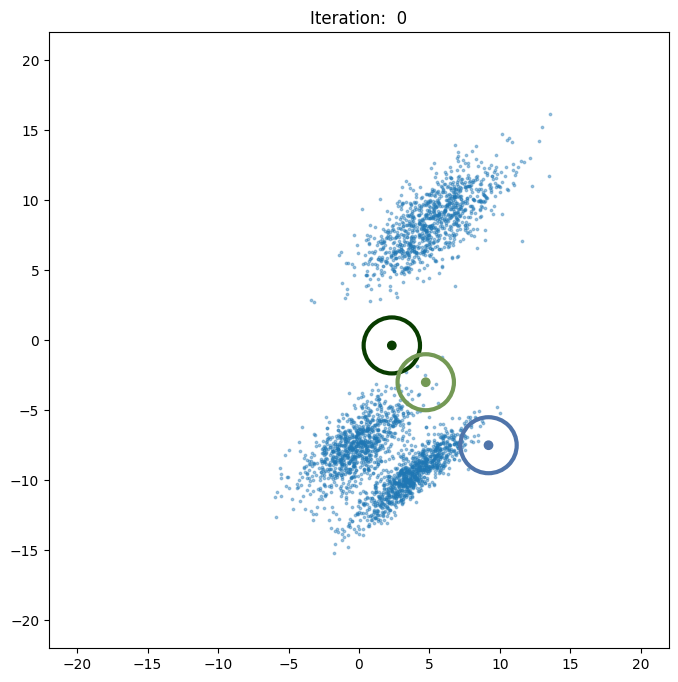

Iteration: 1, log-likelihood: -14881.7820


<Figure size 640x480 with 0 Axes>

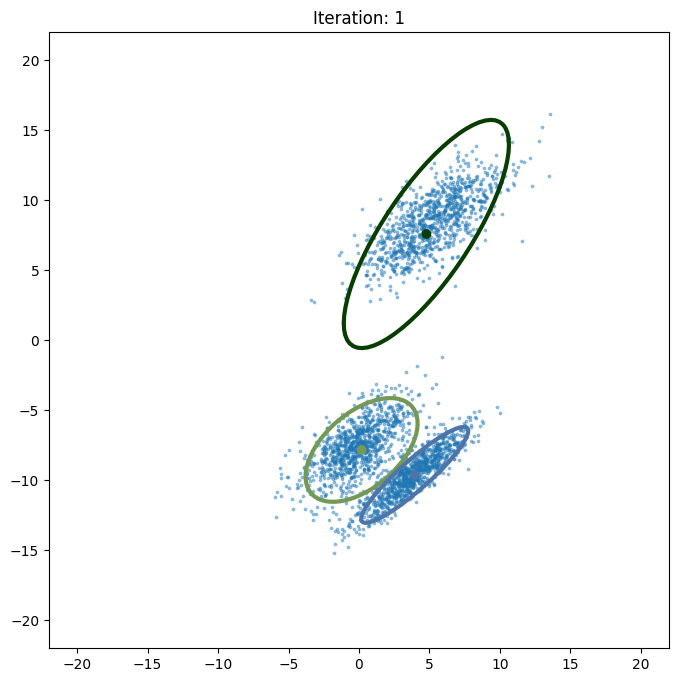

Iteration: 2, log-likelihood: -14482.0520


<Figure size 640x480 with 0 Axes>

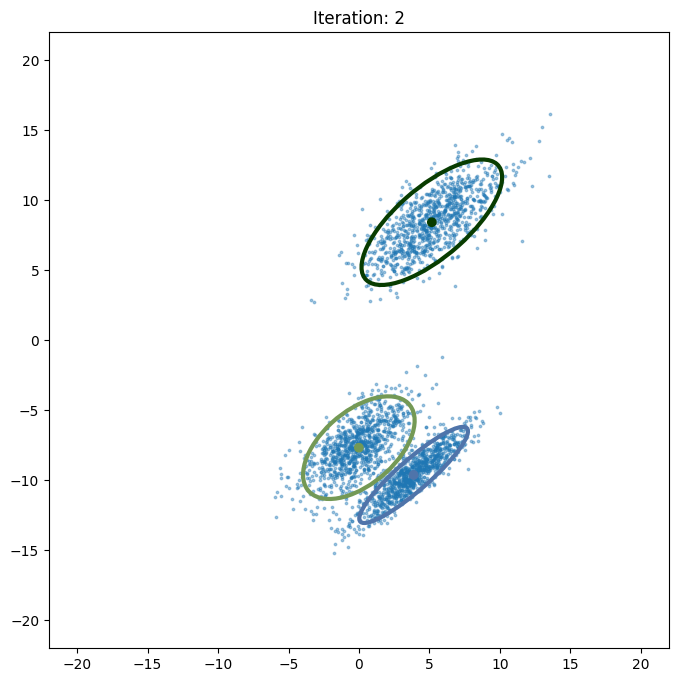

Iteration: 3, log-likelihood: -14461.8076


<Figure size 640x480 with 0 Axes>

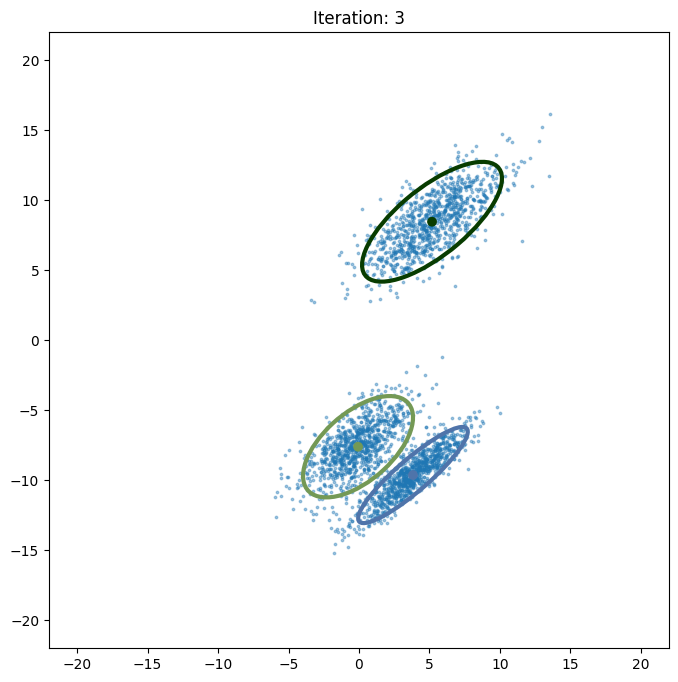

Iteration: 4, log-likelihood: -14455.0141


<Figure size 640x480 with 0 Axes>

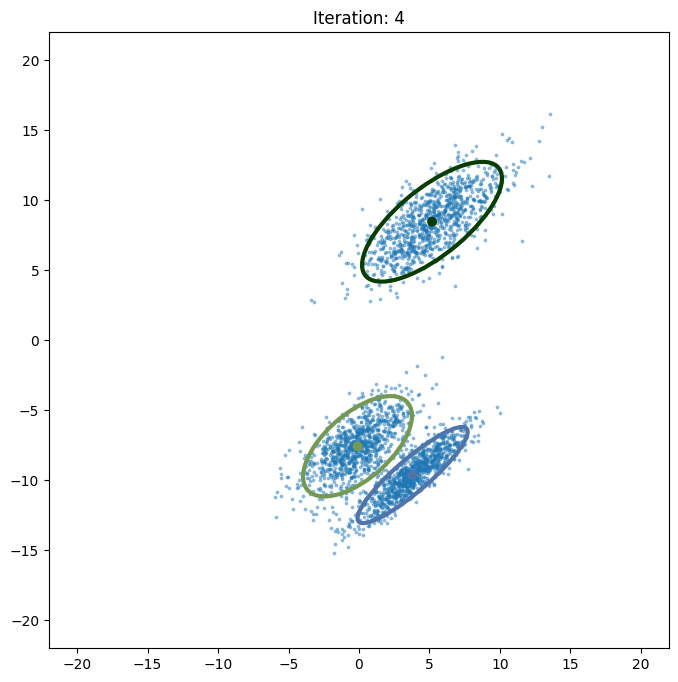

Iteration: 5, log-likelihood: -14452.8938


<Figure size 640x480 with 0 Axes>

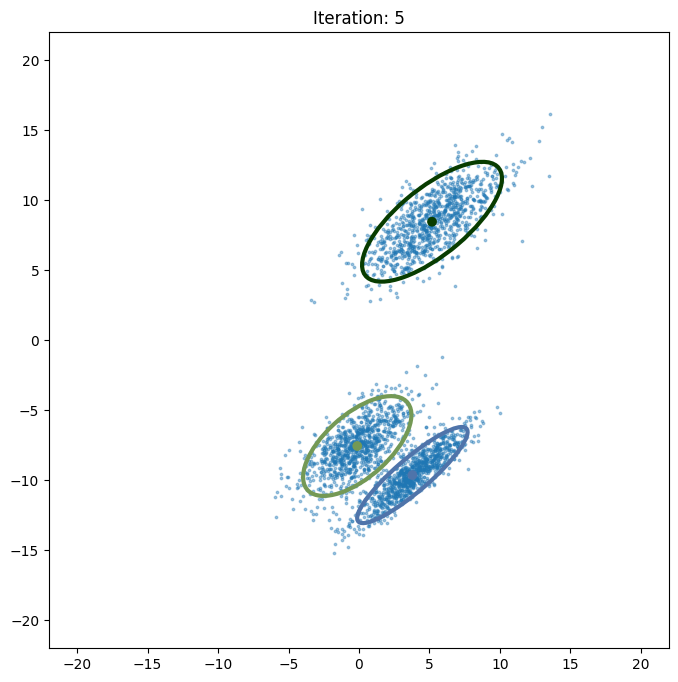

Iteration: 6, log-likelihood: -14452.3292


<Figure size 640x480 with 0 Axes>

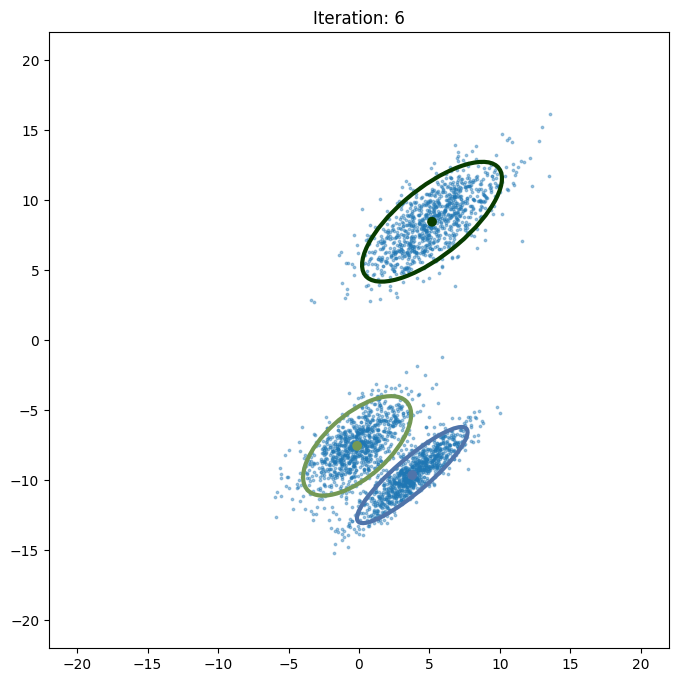

Iteration: 7, log-likelihood: -14452.1895


<Figure size 640x480 with 0 Axes>

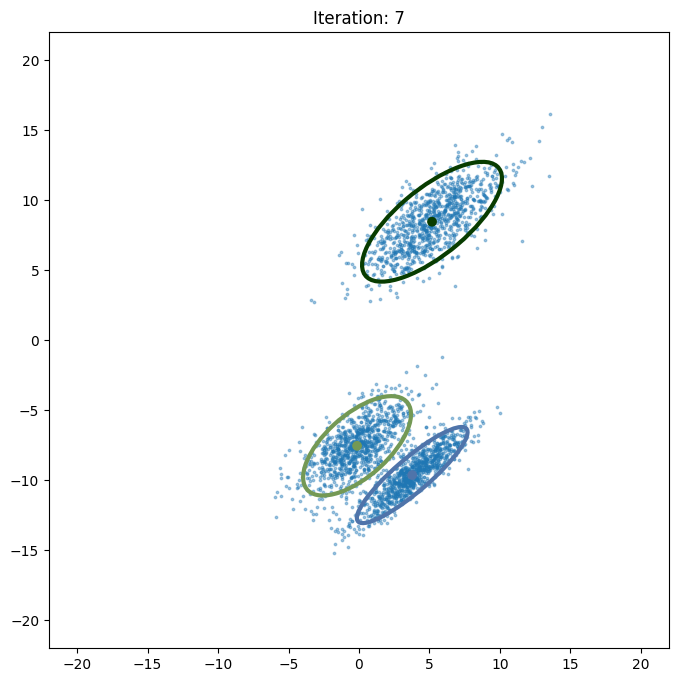

Iteration: 8, log-likelihood: -14452.1560


<Figure size 640x480 with 0 Axes>

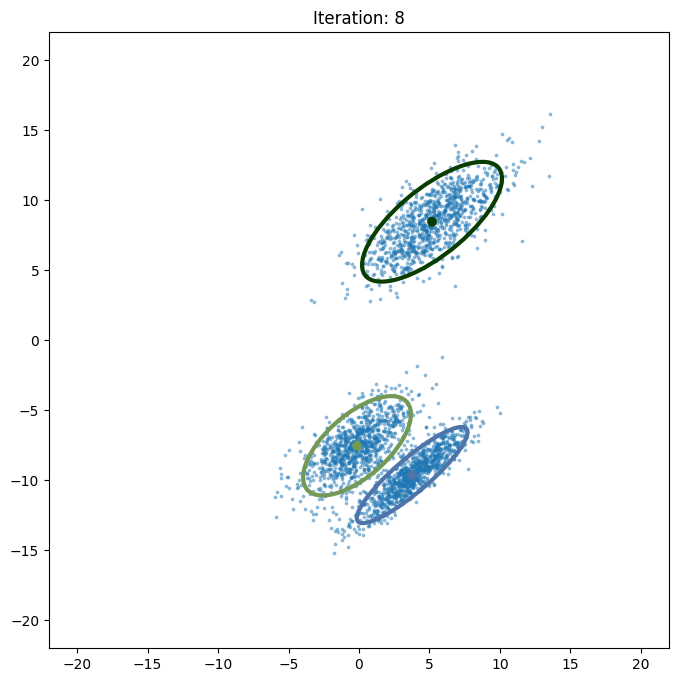

Iteration: 9, log-likelihood: -14452.1481


<Figure size 640x480 with 0 Axes>

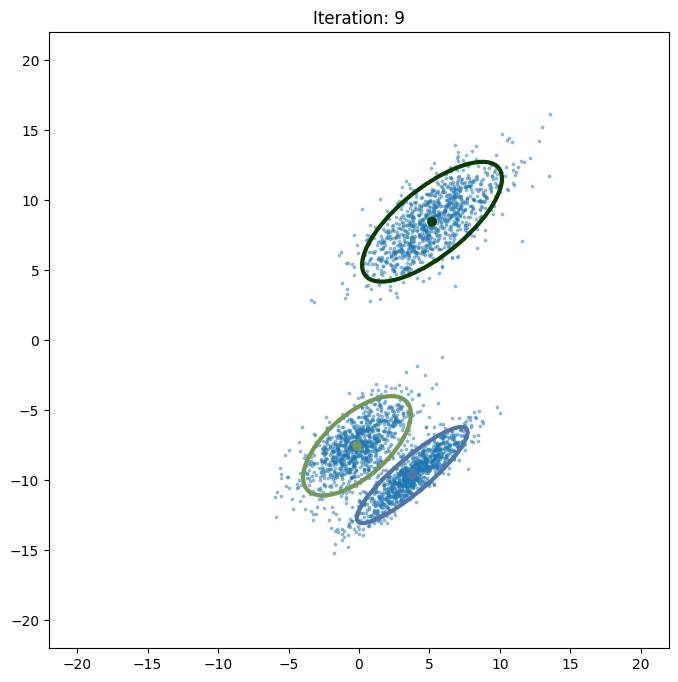

Iteration: 10, log-likelihood: -14452.1463


<Figure size 640x480 with 0 Axes>

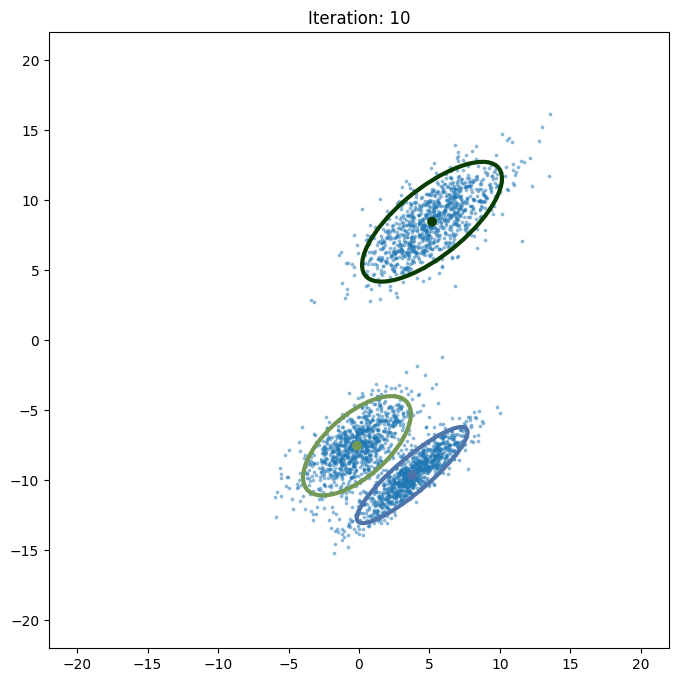

Iteration: 11, log-likelihood: -14452.1458


<Figure size 640x480 with 0 Axes>

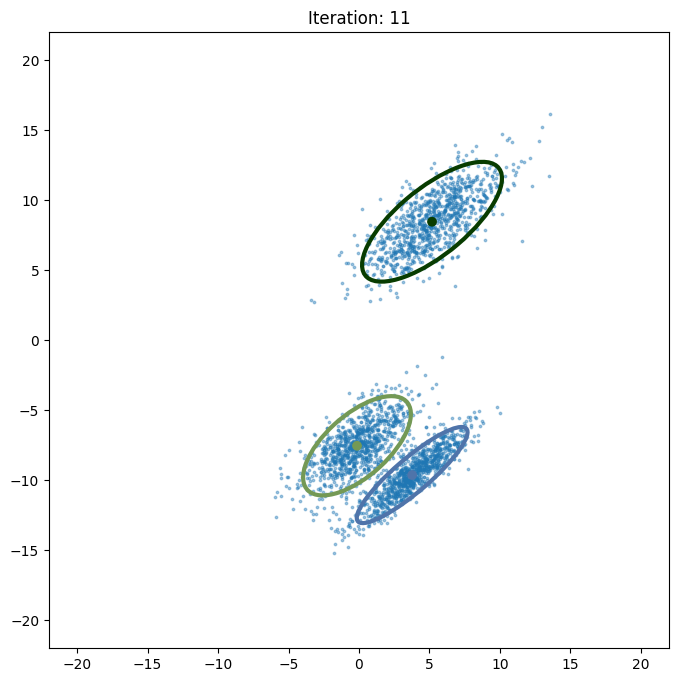

Iteration: 12, log-likelihood: -14452.1457


<Figure size 640x480 with 0 Axes>

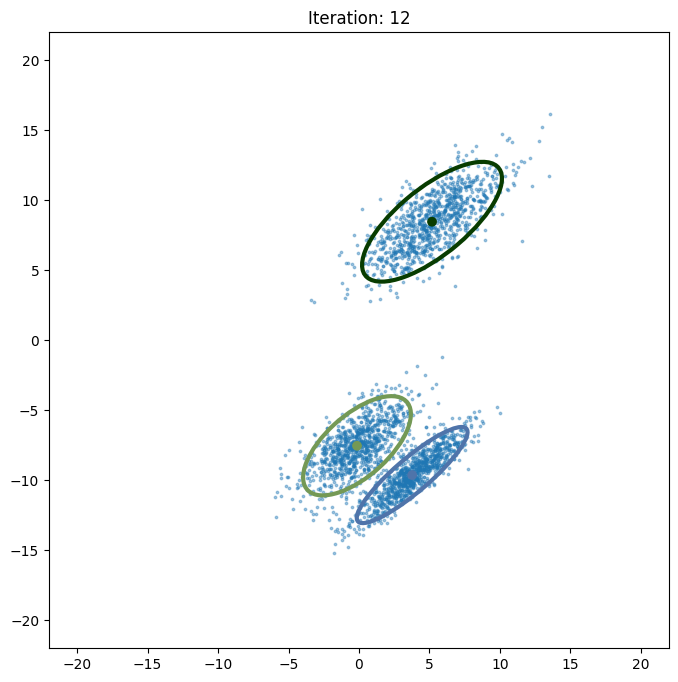

Iteration: 13, log-likelihood: -14452.1457


<Figure size 640x480 with 0 Axes>

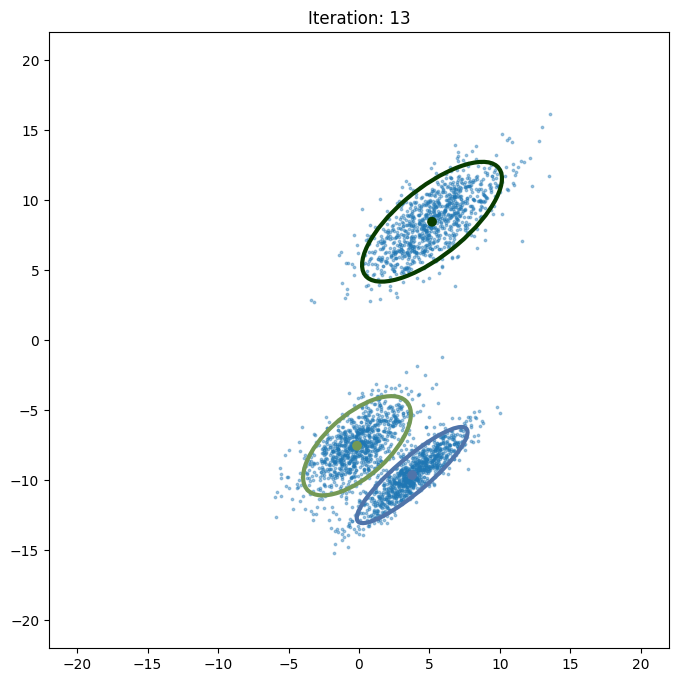

Iteration: 14, log-likelihood: -14452.1457


<Figure size 640x480 with 0 Axes>

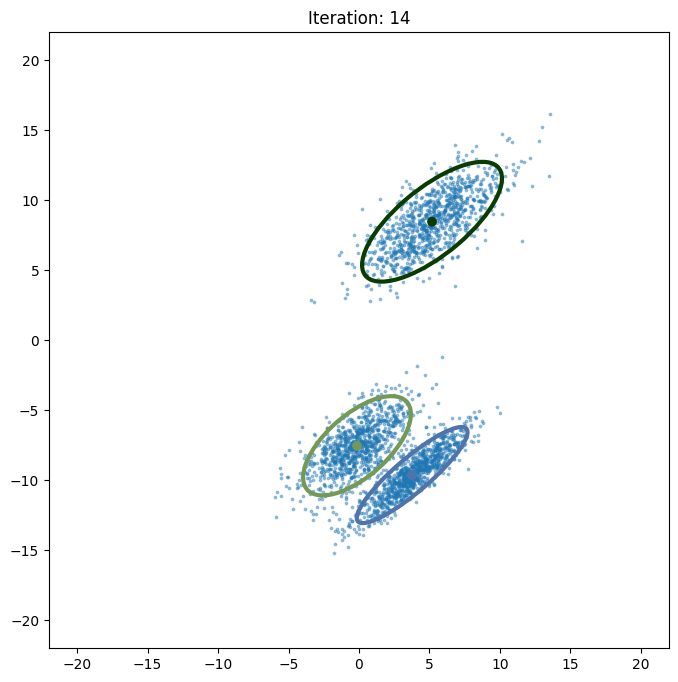

Iteration: 15, log-likelihood: -14452.1457


<Figure size 640x480 with 0 Axes>

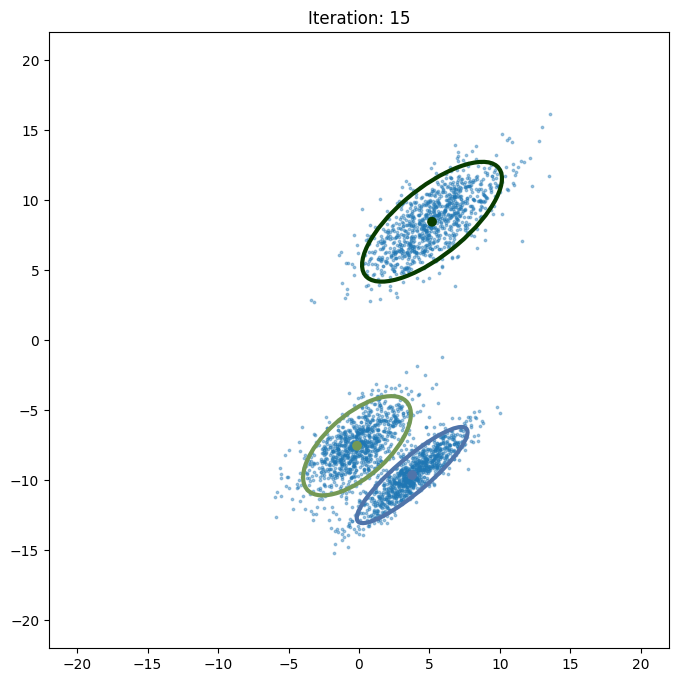

Iteration: 16, log-likelihood: -14452.1457


<Figure size 640x480 with 0 Axes>

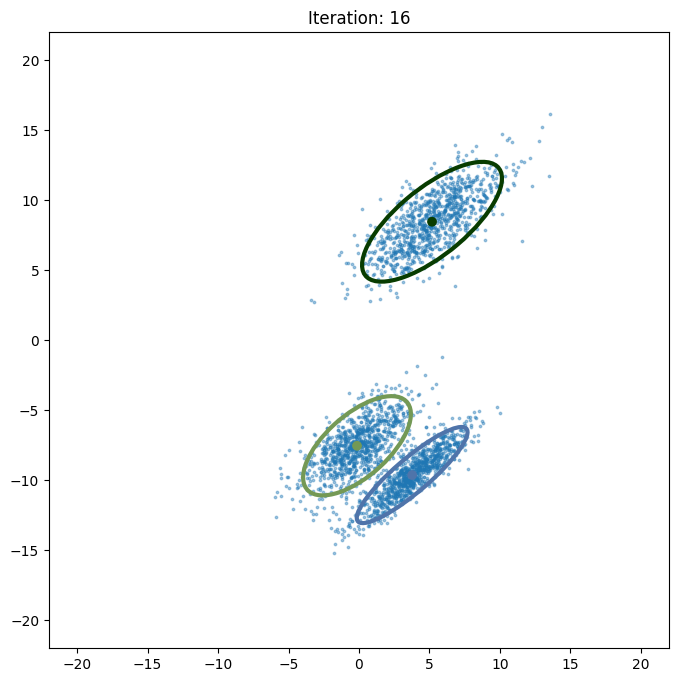

Iteration: 17, log-likelihood: -14452.1457


<Figure size 640x480 with 0 Axes>

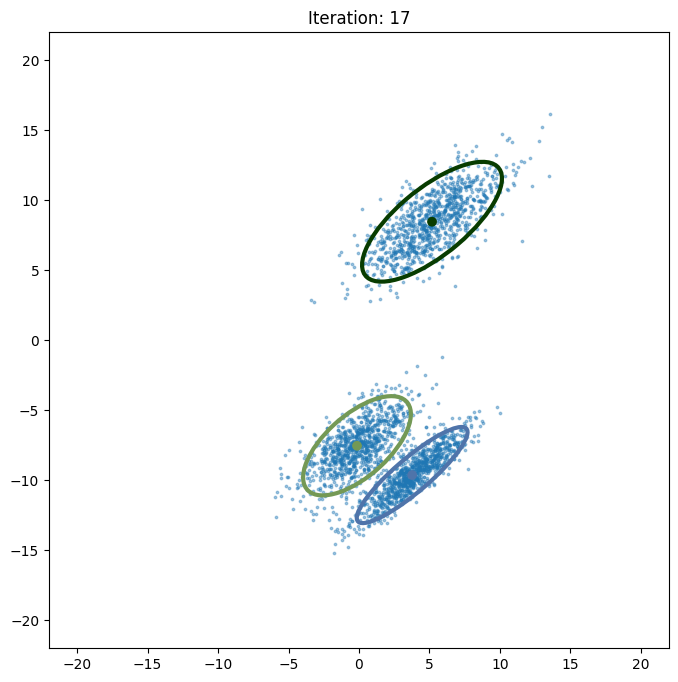

Iteration: 18, log-likelihood: -14452.1457


<Figure size 640x480 with 0 Axes>

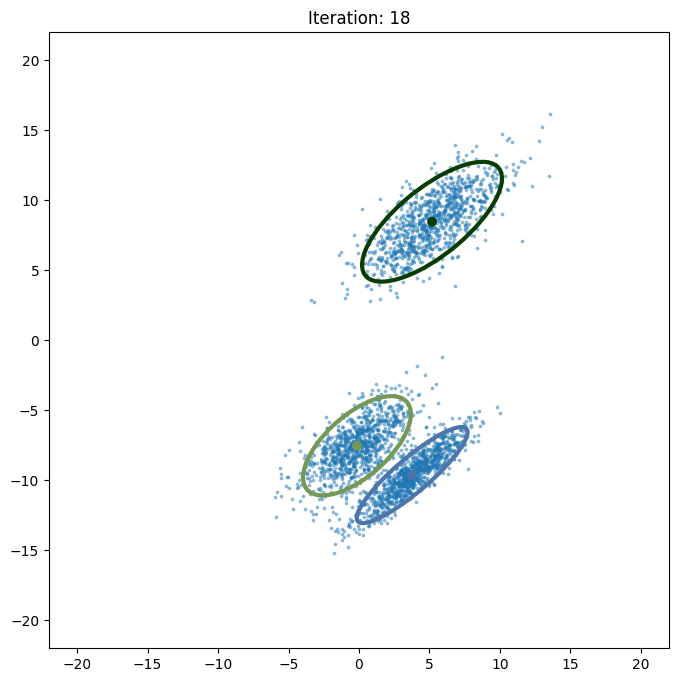

Iteration: 19, log-likelihood: -14452.1457


<Figure size 640x480 with 0 Axes>

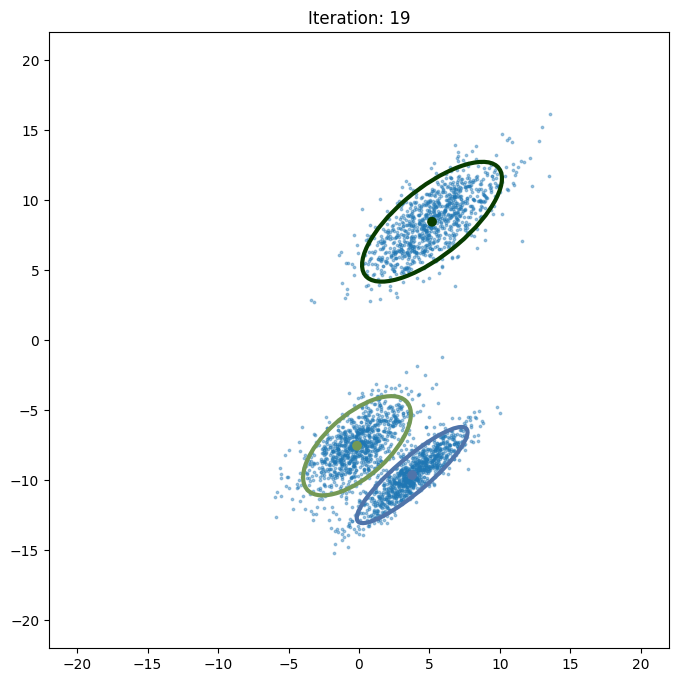

Iteration: 20, log-likelihood: -14452.1457


<Figure size 640x480 with 0 Axes>

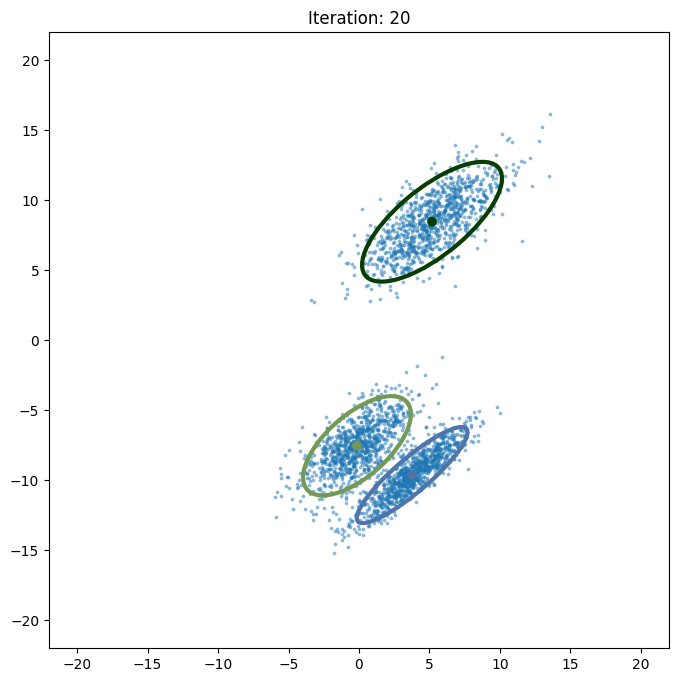

<Figure size 640x480 with 0 Axes>

In [46]:
# Training the GMM using EM

# Initialize EM algo with data
gmm.init_em(X)

num_iters = 20
# Saving log-likelihood
log_likelihood = [gmm.log_likelihood(X)]
# plotting
plot("Iteration:  0")
for e in range(num_iters):
    # E-step
    gmm.e_step()
    # M-step
    gmm.m_step()
    # Computing log-likelihood
    log_likelihood.append(gmm.log_likelihood(X))
    print("Iteration: {}, log-likelihood: {:.4f}".format(e+1, log_likelihood[-1]))
    # plotting
    plot(title="Iteration: " + str(e+1))

In [47]:
print(gmm.mu[:, 0], gmm.mu[:, 1])

[ 5.18384856 -0.14018997  3.77483269] [ 8.46626749 -7.535292   -9.62519982]


In [48]:
gmm_mu_1 = gmm.mu[:, 0]
gmm_mu_2 = gmm.mu[:, 1]


gmm_mu = np.column_stack((gmm_mu_1, gmm_mu_2))

gmm_mu.shape

(3, 2)

In [49]:
gmm_mu

array([[ 5.18384856,  8.46626749],
       [-0.14018997, -7.535292  ],
       [ 3.77483269, -9.62519982]])

In [50]:
cluster_labels = gmm.assign_clusters()

In [51]:
cluster_labels

array([2, 2, 2, ..., 1, 1, 1], dtype=int64)

# Bài tập tự thực hành 2: Sử dụng Kmeans để phân cụm dữ liệu vừa tạo

In [52]:
X.shape

(3000, 2)

In [53]:
N = 1000
K = 3

In [54]:
# Gán nhãn ban đầu cho các cụm, sau đó ta test model và so sánh
original_label = np.asarray([0] * N + [1] * N + [2] * N).T
original_label.shape

(3000,)

In [55]:
from scipy.spatial.distance import cdist


# hiển thị tập dữ liệu X lên mặt phẳng
def kmeans_display(X, label):
    K = np.amax(label) + 1
    X0 = X[label == 0, :]
    X1 = X[label == 1, :]
    X2 = X[label == 2, :]

    plt.plot(X0[:, 0], X0[:, 1], 'b^', markersize=4, alpha=.8)
    plt.plot(X1[:, 0], X1[:, 1], 'go', markersize=4, alpha=.8)
    plt.plot(X2[:, 0], X2[:, 1], 'rs', markersize=4, alpha=.8)
    plt.axis('equal')
    plt.plot()
    plt.show()


# Khởi tạo điểm trung tâm cụm ban đầu
def kmeans_init_centers(X, k):
    # randomly pick k rows of X as initial centers
    return X[np.random.choice(X.shape[0], k, replace=False)]


# gán nhán mới cho các điểm khi biết các centers.
def kmeans_assign_labels(X, centers):
    # calculate pairwise distances btw data and centers
    D = cdist(X, centers)
    # return index of the closest center
    return np.argmin(D, axis=1)


# Cập nhật điểm centers mới dựa trên dữ liệu mới đc gán nhãn
# Tâm cụm mới sẽ là trung bình cộng (theo tọa độ) của tất cả các điểm có trong cụm)
def kmeans_update_centers(X, labels, K):
    centers = np.zeros((K, X.shape[1]))
    for k in range(K):
        # collect all points assigned to the k-th cluster
        Xk = X[labels == k, :]
        # take average
        centers[k, :] = np.mean(Xk, axis=0)
    return centers


# Kiểm tra điều kiện dừng
# Nếu tâm cụm không đổi nghĩa là thuật toán đã dừng (hội tụ) -? TRUE
def has_converged(centers, new_centers):
    # return True if two sets of centers are the same
    return (set([tuple(a) for a in centers]) ==
            set([tuple(a) for a in new_centers]))


# vòng lặp thực hiện tất cả các bước trong thuật toán k-means cho đến khi thuật toán dừng
def kmeans_np(X, K):
    centers = [kmeans_init_centers(X, K)]
    labels = []
    it = 0
    while True:
        labels.append(kmeans_assign_labels(X, centers[-1]))
        new_centers = kmeans_update_centers(X, labels[-1], K)

        if has_converged(centers[-1], new_centers):
            break

        centers.append(new_centers)
        it += 1

    return (centers, labels, it)

Centers found by our algorithm:
[[ 4.07499645 -8.8408201 ]
 [ 5.18384857  8.46626748]
 [-0.47708005 -8.3133844 ]]


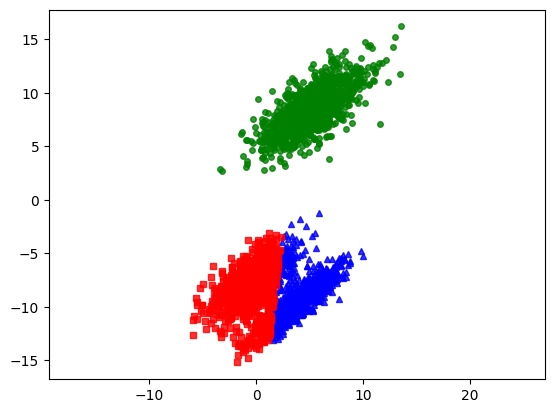

In [56]:
(center_km, labels_km, it) = kmeans_np(X, K)
print('Centers found by our algorithm:')
print(center_km[-1])
kmeans_display(X, labels_km[-1])

## So sánh

In [ ]:
from sklearn.metrics import silhouette_score

silhouette_kmeans = silhouette_score(original_label.reshape(-1, 1), labels_km[-1].reshape(-1, 1))
silhouette_gmm = silhouette_score(original_label.reshape(-1, 1), cluster_labels)

In [71]:
silhouette_kmeans

0.7067327074547206

In [72]:
silhouette_gmm

0.9774683462172046

## Nhận xét
silhouette-score là một chỉ số dùng để đánh giá chất lượng phân cụm, có giá trị từ [-1, 1]
silhouette-score càng gần 1 thể hiện rằng các điểm trong cùng một cụm gần nhau và tách biệt rõ ràng với các cụm khác, trong khi một silhouette score càng gần -1 thể hiện rằng các điểm có thể đã được gán sai nhãn cụm. Khi silhouette score gần 0, điều này có nghĩa là các cụm có thể chồng lấn lên nhau hoặc có các cụm có kích thước không đồng đều.


chỉ số silhouette_gmm cho Gaussian Mixture model thu được là 0.9774683462172046, gần với 1 => GMM thực hiện phân cụm rất tốt, các điểm dữ liệu trong cụm gần nhau và tách biệt rõ ràng với các cụm khác

chỉ số silhouette_kmeans cho Kmeans thu được là 0.7067327074547206 không tốt như sử dụng GMM. Điều này có thể giải thích là do GMM có khả năng mô hình hóa các phân phối dữ liệu phức tạp,và có thể xử lý được các cụm có hình dạng, kích thước không đồng đều. Trong khi đó K-means giả định rằng các cụm có hình dạng hình cầu và có kích thước tương tự nhau. Như trong ví dụ trên, dữ liệu được sinh ra sao cho ma trận hiệp phương sai không song song với trục tọa độ.

# Ví dụ 2

In [76]:
# thư viện cần thiết
import numpy as np
import pandas as pd
import seaborn as sns
import itertools
from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
from matplotlib.patches import Ellipse
from sklearn.preprocessing import MinMaxScaler

from sklearn.mixture import GaussianMixture

In [77]:
# i - đọc dữ liệu
data = pd.read_csv("shopping-data.csv", header=0,index_col=0)

print(data.shape)

(200, 4)


In [78]:
data.head()

,Genre,Age,Annual Income (k$),Spending Score (1-100)
CustomerID,,,,
1,Male,19,15,39
2,Male,21,15,81
3,Female,20,16,6
4,Female,23,16,77
5,Female,31,17,40


In [79]:
# i - chuẩn hóa dữ liệu

# Lấy ra thu nhập va điểm shopping
X = data.iloc[:, 2:4].values

# Chuẩn hoá dữ liệu
std = MinMaxScaler()

X_std = std.fit_transform(X)
print(X_std.shape)

(200, 2)


In [80]:
# ii
# Khởi tạo đối tượng mô hình GaussianMixture
gm = GaussianMixture(n_components=5,
covariance_type='full',
random_state=0)

In [81]:
#iii
# khớp dữ liệu bằng đối tượng mô hình vừa tạo:
gm.fit(X_std)
print('means: \n', gm.means_)
print('covariances: \n ', gm.covariances_)

means: 
 [[0.33368985 0.49394756]
 [0.60502531 0.15433196]
 [0.58393969 0.82673863]
 [0.09861098 0.21597752]
 [0.0829305  0.80743088]]
covariances: 
  [[[ 0.00613567 -0.00231927]
  [-0.00231927  0.0051635 ]]

 [[ 0.01818446  0.00433814]
  [ 0.00433814  0.00873064]]

 [[ 0.01808598 -0.00031096]
  [-0.00031096  0.0091568 ]]

 [[ 0.00453005  0.00255303]
  [ 0.00255303  0.01918353]]

 [[ 0.00337483 -0.0001437 ]
  [-0.0001437   0.01026088]]]


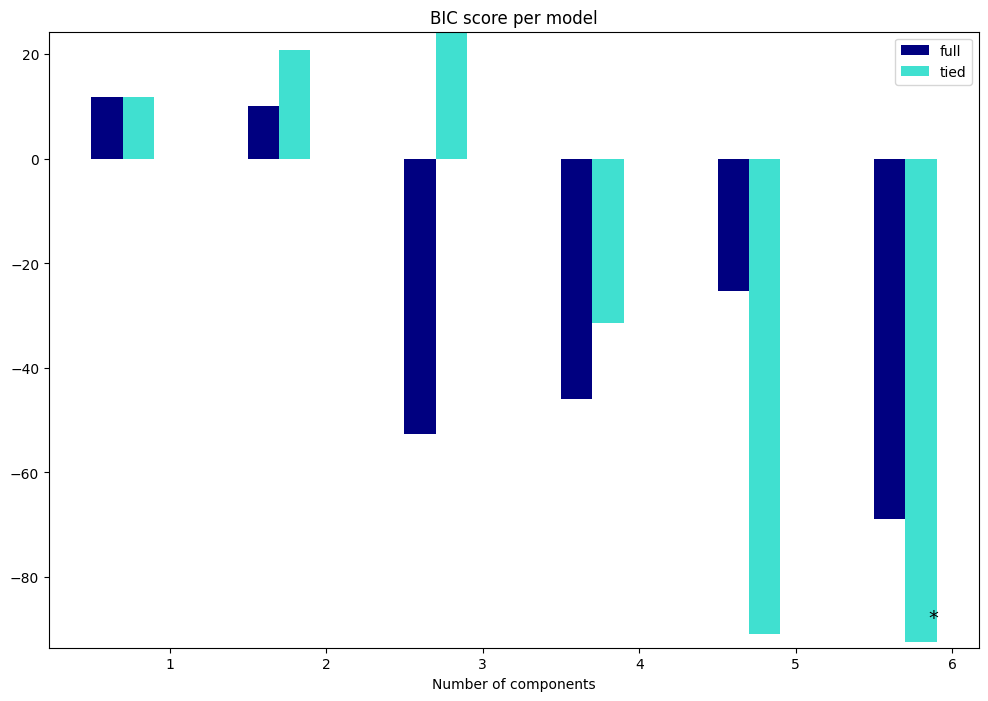

In [82]:
lowest_bic = np.infty
bic = []
n_components_range = range(1, 7)
# cv_types = ['spherical', 'tied', 'diag', 'full']
cv_types = ['full', 'tied']
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit Gaussian mixture theo phương pháp huấn luyện EM
        gmm = GaussianMixture(n_components=n_components,
        covariance_type=cv_type)
        
        gmm.fit(X_std)
        bic.append(gmm.bic(X_std))
        
        # Gán model có BIC scores thấp nhất là model tốt nhất
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm
    
bic = np.array(bic)
color_iter = itertools.cycle(['navy', 'turquoise'])
clf = best_gmm
bars = []

# Vẽ biểu đồ BIC scores
plt.figure(figsize=(12, 8))
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, bic[i * len(n_components_range):
    (i + 1) * len(n_components_range)],
    width=.2, color=color))
    
plt.xticks(n_components_range)

plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('BIC score per model')

xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 +\
.2 * np.floor(bic.argmin() / len(n_components_range))
plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
plt.xlabel('Number of components')
plt.legend([b[0] for b in bars], cv_types)

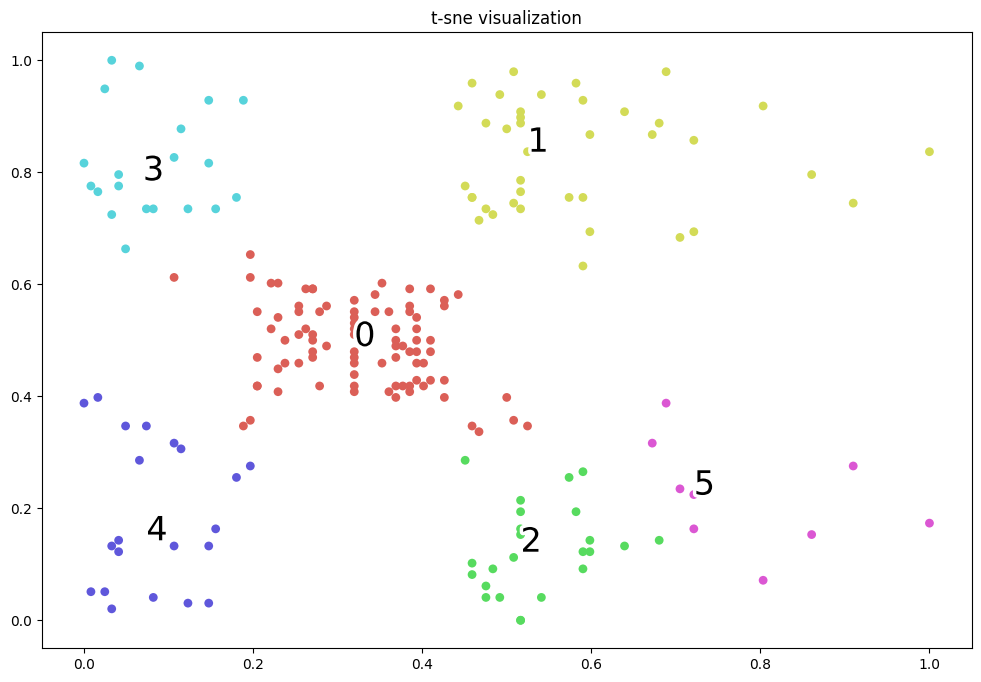

In [84]:
# iv - Hiển thị kết quả
def _plot_kmean_scatter(X, labels):
    '''
    X: dữ liệu đầu vào
    labels: nhãn dự báo
    '''
    # lựa chọn màu sắc
    num_classes = len(np.unique(labels))
    palette = np.array(sns.color_palette("hls", num_classes))
    
    # vẽ biểu đồ scatter
    fig = plt.figure(figsize=(12, 8))
    ax = plt.subplot()
    sc = ax.scatter(X[:,0], X[:,1], lw=0, s=40,
    
    c=palette[labels.astype(int)])
    
    # thêm nhãn cho mỗi cluster
    txts = []
    
    for i in range(num_classes):
        # Vẽ text tên cụm tại trung vị của mỗi cụm
        xtext, ytext = np.median(X[labels == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
        PathEffects.Stroke(linewidth=5, foreground="w"),
        PathEffects.Normal()])
        txts.append(txt)
        
    plt.title('t-sne visualization')
    

# Gọi và thực hiện 2 phương thức chính: Thực hiện mô hình trộn Gaussian và phương thức hiển thị dữ liệu ra mặt phẳng 2 chiều để dễ quan sát.
labels = best_gmm.predict(X_std)
_plot_kmean_scatter(X_std, labels)

# Ví dụ mở rộng

## Sử dụng code ví dụ 1

In [217]:
class GMM():
    def __init__(self, k, dim, init_mu=None, init_sigma=None, init_pi=None, colors=None):
        '''
        Define a model with known number of clusters and dimensions.
        input:
            - k: Number of Gaussian clusters
            - dim: Dimension 
            - init_mu: initial value of mean of clusters (k, dim)
                       (default) random from uniform[-10, 10]
            - init_sigma: initial value of covariance matrix of clusters (k, dim, dim)
                          (default) Identity matrix for each cluster
            - init_pi: initial value of cluster weights (k,)
                       (default) equal value to all cluster i.e. 1/k
            - colors: Color valu for plotting each cluster (k, 3)
                      (default) random from uniform[0, 1]
        '''
        self.k = k
        self.dim = dim
        if(init_mu is None):
            init_mu = random.rand(k, dim)*20 - 10
        self.mu = init_mu
        if(init_sigma is None):
            init_sigma = np.zeros((k, dim, dim))
            for i in range(k):
                init_sigma[i] = np.eye(dim)
        self.sigma = init_sigma
        
        if(init_pi is None):
            init_pi = np.ones(self.k)/self.k
        self.pi = init_pi
        
        if(colors is None):
            colors = random.rand(k, 3)
            for i in range(k):
                colors[i, 2] = i/k
        self.colors = colors
    
    def init_em(self, X):
        '''
        Initialization for EM algorithm.
        input:
            - X: data (batch_size, dim)
        '''
        self.data = X
        self.num_points = X.shape[0]
        self.z = np.zeros((self.num_points, self.k))
    
    # def e_step(self):
    #     '''
    #     E-step of EM algorithm.
    #     '''
    #     for i in range(self.k):
    #         self.z[:, i] = self.pi[i] * multivariate_normal.pdf(self.data, mean=self.mu[i], cov=self.sigma[i])
    #     self.z /= self.z.sum(axis=1, keepdims=True)
    
    
    def e_step(self):
        '''
        Bước E của thuật toán EM.
        '''
        for i in range(self.k):
            # Tính toán xác suất ẩn cho từng điểm dữ liệu và mỗi cụm Gaussian
            self.z[:, i] = self.pi[i] * multivariate_normal.pdf(self.data, mean=self.mu[i], cov=self.sigma[i])
    
    
        # Xử lý trường hợp xác suất ẩn bằng 0 hoặc tiến gần đến 0
        self.z[self.z < 1e-10] = 1e-10

        # Chuẩn hóa xác suất ẩn để tổng xác suất ẩn của mỗi điểm dữ liệu bằng 1
        self.z /= self.z.sum(axis=1, keepdims=True)

    
    # def m_step(self):
    #     '''
    #     M-step of EM algorithm.
    #     '''
    #     sum_z = self.z.sum(axis=0)
    #     self.pi = sum_z / self.num_points
    #     self.mu = np.matmul(self.z.T, self.data)
    #     self.mu /= sum_z[:, None]
    #     for i in range(self.k):
    #         j = np.expand_dims(self.data, axis=1) - self.mu[i]
    #         s = np.matmul(j.transpose([0, 2, 1]), j)
    #         self.sigma[i] = np.matmul(s.transpose(1, 2, 0), self.z[:, i] )
    #         self.sigma[i] /= sum_z[i]
    # 
    # def m_step(self):
    #     '''
    #     M-step of EM algorithm.
    #     '''
    #     sum_z = self.z.sum(axis=0)
    #     self.pi = sum_z / self.num_points
    #     for i in range(self.k):
    #         self.mu[i] = np.sum(self.z[:, i, None] * self.data, axis=0) / sum_z[i]
    #         diff = self.data - self.mu[i]
    #         self.sigma[i] = np.dot((self.z[:, i, None] * diff).T, diff) / sum_z[i]

    
    def m_step(self):
        '''
        Bước M của thuật toán EM.
        '''
        sum_z = self.z.sum(axis=0)
        self.pi = sum_z / self.num_points

        # Tính giá trị trung bình mới
        self.mu = np.dot(self.z.T, self.data) / sum_z[:, None]

        # Tính ma trận hiệp phương sai mới
        for i in range(self.k):
            # Tính toán hiệp phương sai dựa trên mảng dữ liệu phát sóng
            diff = self.data - self.mu[i]
            self.sigma[i] = np.dot(self.z[:, i] * diff.T, diff) / sum_z[i]

    def log_likelihood(self, X):
        '''
        Compute the log-likelihood of X under current parameters
        input:
            - X: Data (batch_size, dim)
        output:
            - log-likelihood of X: Sum_n Sum_k log(pi_k * N( X_n | mu_k, sigma_k ))
        '''
        ll = []
        for d in X:
            tot = 0
            for i in range(self.k):
                tot += self.pi[i] * multivariate_normal.pdf(d, mean=self.mu[i], cov=self.sigma[i])
            ll.append(np.log(tot))
        return np.sum(ll)
    
    def plot_gaussian(self, mean, cov, ax, n_std=3.0, facecolor='none', **kwargs):
        '''
        Utility function to plot one Gaussian from mean and covariance.
        '''
        pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
        ell_radius_x = np.sqrt(1 + pearson)
        ell_radius_y = np.sqrt(1 - pearson)
        ellipse = Ellipse((0, 0),
            width=ell_radius_x * 2,
            height=ell_radius_y * 2,
            facecolor=facecolor,
            **kwargs)
        scale_x = np.sqrt(cov[0, 0]) * n_std
        mean_x = mean[0]
        scale_y = np.sqrt(cov[1, 1]) * n_std
        mean_y = mean[1]
        transf = transforms.Affine2D() \
            .rotate_deg(45) \
            .scale(scale_x, scale_y) \
            .translate(mean_x, mean_y)
        ellipse.set_transform(transf + ax.transData)
        return ax.add_patch(ellipse)


    def draw(self, ax, n_std=2.0, facecolor='none', **kwargs):
        '''
        Function to draw the Gaussians.
        Note: Only for two-dimensionl dataset
        '''
        if(self.dim != 2):
            print("Drawing available only for 2D case.")
            return
        for i in range(self.k):
            self.plot_gaussian(self.mu[i], self.sigma[i], ax, n_std=n_std, edgecolor=self.colors[i], **kwargs)

In [218]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Đọc dữ liệu
data = pd.read_csv('Sales_Transactions_Dataset_Weekly.csv')

data.shape

(811, 107)

In [219]:
data.head()

,Product_Code,W0,W1,W2,W3,W4,W5,W6,W7,W8,...,Normalized 42,Normalized 43,Normalized 44,Normalized 45,Normalized 46,Normalized 47,Normalized 48,Normalized 49,Normalized 50,Normalized 51
0,P1,11,12,10,8,13,12,14,21,6,...,0.06,0.22,0.28,0.39,0.50,0.00,0.22,0.17,0.11,0.39
1,P2,7,6,3,2,7,1,6,3,3,...,0.20,0.40,0.50,0.10,0.10,0.40,0.50,0.10,0.60,0.00
2,P3,7,11,8,9,10,8,7,13,12,...,0.27,1.00,0.18,0.18,0.36,0.45,1.00,0.45,0.45,0.36
3,P4,12,8,13,5,9,6,9,13,13,...,0.41,0.47,0.06,0.12,0.24,0.35,0.71,0.35,0.29,0.35
4,P5,8,5,13,11,6,7,9,14,9,...,0.27,0.53,0.27,0.60,0.20,0.20,0.13,0.53,0.33,0.40


In [220]:
# lấy ra các cột chứa thông tin giao dịch đã chuẩn hóa theo từng tuần
data_normalized_weekly = data.iloc[:, 55:] 

data_normalized_weekly.head()

,Normalized 0,Normalized 1,Normalized 2,Normalized 3,Normalized 4,Normalized 5,Normalized 6,Normalized 7,Normalized 8,Normalized 9,...,Normalized 42,Normalized 43,Normalized 44,Normalized 45,Normalized 46,Normalized 47,Normalized 48,Normalized 49,Normalized 50,Normalized 51
0,0.44,0.50,0.39,0.28,0.56,0.50,0.61,1.00,0.17,0.61,...,0.06,0.22,0.28,0.39,0.50,0.00,0.22,0.17,0.11,0.39
1,0.70,0.60,0.30,0.20,0.70,0.10,0.60,0.30,0.30,0.30,...,0.20,0.40,0.50,0.10,0.10,0.40,0.50,0.10,0.60,0.00
2,0.36,0.73,0.45,0.55,0.64,0.45,0.36,0.91,0.82,0.27,...,0.27,1.00,0.18,0.18,0.36,0.45,1.00,0.45,0.45,0.36
3,0.59,0.35,0.65,0.18,0.41,0.24,0.41,0.65,0.65,0.53,...,0.41,0.47,0.06,0.12,0.24,0.35,0.71,0.35,0.29,0.35
4,0.33,0.13,0.67,0.53,0.20,0.27,0.40,0.73,0.40,0.40,...,0.27,0.53,0.27,0.60,0.20,0.20,0.13,0.53,0.33,0.40


In [221]:
data = data_normalized_weekly.values

data.shape

(811, 52)

In [222]:
print(data[1:3])

[[0.7  0.6  0.3  0.2  0.7  0.1  0.6  0.3  0.3  0.3  0.2  0.2  0.6  0.2
  0.   0.6  0.2  0.7  0.7  0.9  0.4  0.7  0.2  0.4  0.5  0.3  0.5  0.8
  0.5  0.5  0.3  0.1  0.3  0.2  0.3  1.   0.5  0.2  0.7  0.3  0.2  0.5
  0.2  0.4  0.5  0.1  0.1  0.4  0.5  0.1  0.6  0.  ]
 [0.36 0.73 0.45 0.55 0.64 0.45 0.36 0.91 0.82 0.27 1.   0.55 0.09 0.36
  0.82 0.45 0.36 0.73 0.64 0.36 0.36 0.91 0.73 0.45 0.64 0.45 1.   0.18
  0.   0.91 0.73 0.55 0.36 0.45 0.36 0.55 0.27 0.82 0.82 0.55 0.   0.18
  0.27 1.   0.18 0.18 0.36 0.45 1.   0.45 0.45 0.36]]


In [254]:
def compute_bic(gmm_model, X):
    '''
    Compute the Bayesian Information Criterion (BIC) for a given GMM model and data.
    input:
        - gmm_model: GMM model
        - X: Data (batch_size, dim)
    output:
        - BIC score
    '''
    n = X.shape[0]  # Number of data points
    d = X.shape[1]  # Dimensionality of data
    k = gmm_model.k  # Number of clusters
    
    log_likelihood = gmm_model.log_likelihood(X)
    num_params = k * (d + d*(d+1)//2)  # Total number of parameters in GMM
    
    bic = -2 * log_likelihood + num_params * np.log(n)
    return bic


# Initialize a list to store BIC scores for different numbers of clusters
bic_scores = []

cluster_range = range(5, 16, 1)

# Iterate over each cluster number
for k in cluster_range:
    # Initialize GMM model with k clusters
    gmm = GMM(k=k, dim=X.shape[1])
    
    # Initialize and fit the model on your data
    gmm.init_em(X)
    for _ in range(500):
        gmm.e_step()
        gmm.m_step()
    
    # Compute BIC score for this model and data
    bic = compute_bic(gmm, X)
    
    # Append the BIC score to the list
    bic_scores.append(bic)

# Find the index of the minimum BIC score
optimal_k_index = np.argmin(bic_scores)

In [255]:
print("Number of k:",cluster_range[optimal_k_index])

Number of k: 5


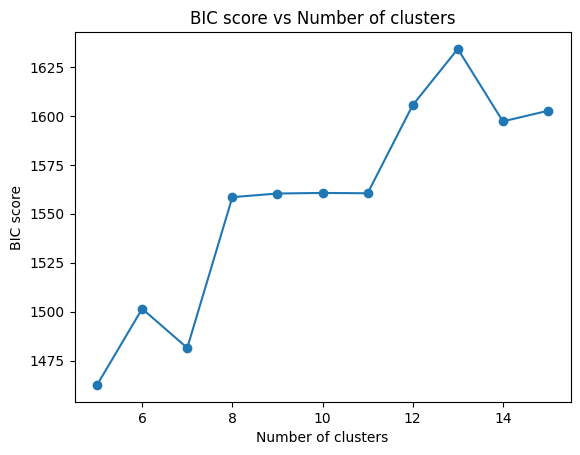

In [256]:
# Plot BIC scores
plt.plot(cluster_range, bic_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('BIC score')
plt.title('BIC score vs Number of clusters')
plt.show()

## Sử dụng thư viện

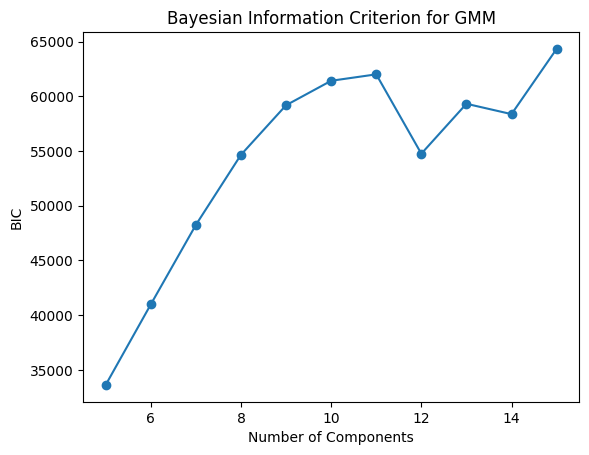

In [257]:
# Áp dụng mô hình GMM
from sklearn.mixture import GaussianMixture

# Tìm số cụm tối ưu
lowest_bic = np.infty
bic = []
n_components_range = range(5, 16, 1)
for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm.fit(data)
    bic.append(gmm.bic(data))
    if bic[-1] < lowest_bic:
        lowest_bic = bic[-1]
        best_gmm = gmm
        best_n_components = n_components

# Phân loại các mã sản phẩm vào các cụm đã được xác định
clusters = best_gmm.predict(data)

# Vẽ biểu đồ thể hiện số lượng cụm tối ưu dựa trên BIC
plt.plot(n_components_range, bic, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('BIC')
plt.title('Bayesian Information Criterion for GMM')
plt.show()

In [258]:
# Lấy số lượng cụm tối ưu
optimal_num_clusters = n_components_range[np.argmin(bic)]
print("Số lượng cụm tối ưu:", optimal_num_clusters)

Số lượng cụm tối ưu: 5
